In [ ]:
!pip install pymorphy2 --quiet
!pip install randan --quiet
!pip install pyLDAvis --quiet
# !pip install pyLDAvis==2.1.2 --quiet

In [ ]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install bertopic  --quiet

In [ ]:
!pip uninstall numba -Y
!pip install numba 

In [678]:
import os
import pandas as pd
import numpy as np
import nltk
from nltk.util import ngrams
import pickle
import sys

import re
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from randan.descriptive_statistics import ScaleStatistics
from randan.dimension_reduction import PCA
import ast
import warnings
warnings.filterwarnings('ignore')


### sklearn - LDA
import itertools

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation,TruncatedSVD
from sklearn.model_selection import GridSearchCV, train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings('ignore')


from tqdm import tqdm_notebook

from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
from bertopic.representation import KeyBERTInspired

## gensim - LDA
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis.gensim

import pickle
import inspect
from copy import deepcopy

## BERT
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic

pickle

In [ ]:
os.chdir('/content/')
# текущая рабочая директория

In [ ]:
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return sorted([var_name for var_name, var_val in callers_local_vars if var_val is var],key=lambda x: len(x))[-1]

In [ ]:
def p_load(name):
    return pickle.load(open(f'{name}.pickle', 'rb'))  

def p_list(var_list):
    vars_to_return = []
    for var_name in var_list:
      vars_to_return.append(p_load(var_name))
    return vars_to_return

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=1)

# Preprocessing

In [ ]:
vk_df = pd.read_csv('final_vk.csv',index_col=0).reset_index(drop=True)
vk_df = vk_df.iloc[vk_df.raw_text.drop_duplicates().index]
vk_df.text = vk_df.text.astype(str).apply(lambda x: ast.literal_eval(x))
vk_df.head()

,raw_text,source,text,length
0,Альтернатива живым цветам - натуральные цветоч...,vsemvermi_messages,"[альтернатива, живой, цвет, натуральный, цвето...",18
1,Альтернатива к цветам - Эко свечи ручной работ...,vsemvermi_messages,"[альтернатива, цвет, свеча, ручной, работа, бо...",12
2,Альтернатива цветам - сладкий подарок-открытка...,vsemvermi_messages,"[альтернатива, цвет, сладкий, подарокоткрытка,...",12
3,Свечи из натурального соевого воска ✨️\n\nПода...,vsemvermi_messages,"[свеча, натуральный, соевый, воск, подарочный,...",18
4,"Мыльные наборы с натуральным составом, алоэ ве...",vsemvermi_messages,"[мыльный, набор, натуральный, состав, алоэ, ве...",13


In [ ]:
vk_df.shape

(14372, 4)

In [ ]:
vk_df.source.value_counts().to_frame()

,count
source,
zerowaste_ru_messages,5187
zerowasterus_messages,2373
greencospb_messages,1874
vk_rsbor_messages,1578
zero_waste_shop_messages,865
sobirator_messages,779
eco_sfera_messages,462
vk_ed_zbs_messages,432
vsemvermi_messages,270


In [ ]:
# vk_df.source.value_counts().to_frame().merge(vk_cleaned.source.value_counts().to_frame(), on='source')

In [ ]:
vk_df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,14372.0,21.481144,16.357481,10.0,12.0,16.0,24.0,199.0


In [ ]:
vk_cleaned = vk_df.query('length >= 10')
# vk_cleaned = vk_df.query('length >= 10')
vk_cleaned.shape

(14372, 4)

In [ ]:
tg_df = pd.read_csv('final_tg.csv',index_col=0).reset_index(drop=True)
tg_df = tg_df.iloc[tg_df.raw_text.drop_duplicates().index]
tg_df.text = tg_df.text.astype(str).apply(lambda x: ast.literal_eval(x))
tg_df.head()

,raw_text,source,text,length
0,Всем привет! \n\nУ нас новости. Мы приняли реш...,zwsmos,"[привет, новость, принять, решение, закрыть, с...",45
1,Мы хотим напомнить об основных правилах хранен...,zwsmos,"[напомнить, основный, правило, хранение, проду...",85
2,Кудрявый метод aka тренд 2022😄\n\nДелитесь сво...,zwsmos,"[кудрявый, метод, тренд, делиться, лайфхак, ку...",23
3,Сегодня хотим поделиться с вами списком товаро...,zwsmos,"[поделиться, список, товар, помочь, сделать, в...",79
4,Почему мы всегда советуем выбирать алюминиевую...,zwsmos,"[советовать, выбирать, алюминиевый, оборотный,...",64


In [ ]:
tg_df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,4966.0,32.575312,30.877171,10.0,13.0,20.0,39.0,199.0


In [ ]:
tg_cleaned = tg_df.query('length >= 10')
tg_cleaned.shape

(4966, 4)

In [ ]:
tg_df.source.value_counts().to_frame().merge(tg_cleaned.source.value_counts().to_frame(), on='source')

,count_x,count_y
source,,
tg_ecochatik_messages,4074,4074
zwsmos,281,281
osoznannoyepotrebleniye,233,233
my_green_bag_messages,232,232
tg_sobirator_messages,146,146


In [ ]:
def str_to_list(x):
  try:
    lst = ast.literal_eval(x)
  except:
    lst = []
  return lst

In [ ]:
# yt_df = pd.read_csv('full_yt_df2.csv',index_col=0).reset_index(drop=True)
# yt_df = yt_df.iloc[yt_df.raw_text.drop_duplicates().index]
# yt_df.text = yt_df.text.astype(str).apply(lambda x: str_to_list(x))
# yt_df = yt_df.rename(columns={'videoId': 'source'})
# # yt_df.source = 'yt'
# yt_df.head()

In [ ]:
# yt_df.source.value_counts()

In [ ]:
# yt_df.shape

In [ ]:
# yt_cleaned = yt_df.query('length >= 10')
# yt_cleaned.shape

In [ ]:
# yt_df.source.value_counts().to_frame().merge(yt_cleaned.source.value_counts().to_frame(), on='source')

In [ ]:
# yt_df.shape, yt_cleaned.shape

In [ ]:
# yt, vk, tg =yt_cleaned, vk_cleaned, tg_cleaned
vk, tg =vk_cleaned, tg_cleaned

# df = tg_cleaned
def generate_n_grams(sent, n):
  sent_n_grams = ngrams(sent,n)
  return ["_".join(ngram) for ngram in sent_n_grams]

for df in [
    # yt, 
    vk, tg]:

  bigrams = df.text.apply(lambda x: generate_n_grams(x, 2))
  df[f'2_grams'] = bigrams

  df['text_comma'] = df['text'].apply(lambda x: ','.join(map(str, x)))

  df['text_space'] = df['text_comma'].apply(lambda x: x.replace(',', ' '))

  df['2_grams_space'] = df['2_grams'].apply(lambda x: ' '.join(x))

df_all = pd.concat([
    # yt, 
    vk, tg])

In [ ]:
df_all.length.describe()

count    19338.000000
mean        24.330127
std         21.613432
min         10.000000
25%         12.000000
50%         17.000000
75%         27.000000
max        199.000000
Name: length, dtype: float64

In [ ]:
docs_df_all_1 = df_all['text_space'].tolist()
docs_df_all_2 = df_all['2_grams_space'].tolist()

In [ ]:
docs_df_all_2[:5]

['альтернатива_живой живой_цвет цвет_натуральный натуральный_цветочный цветочный_эфирный эфирный_масло масло_парфюм парфюм_гармонизатор гармонизатор_эмоциональный эмоциональный_состояние состояние_средство средство_улучшение улучшение_гормональный гормональный_состояние состояние_женский женский_группа группа_масло',
 'альтернатива_цвет цвет_свеча свеча_ручной ручной_работа работа_божественный божественный_аромат аромат_открытка открытка_красивый красивый_упаковка упаковка_идти идти_стоимость',
 'альтернатива_цвет цвет_сладкий сладкий_подарокоткрытка подарокоткрытка_бентоторт бентоторт_бывать бывать_разный разный_размер размер_дизайн дизайн_надпись надпись_желание желание_рад',
 'свеча_натуральный натуральный_соевый соевый_воск воск_подарочный подарочный_оформление оформление_миниоткрытка миниоткрытка_входить входить_стоимость стоимость_наличие наличие_большой большой_выбор выбор_бесплатный бесплатный_доставка доставка_всеволожск всеволожск_близлежайшие близлежайшие_населить населить_п

# Vectorizer

In [630]:
def vectorizer(df, ngram_range=(1,1), min_df=5, mode='c'):
  if mode == 'c':
      cvect = CountVectorizer(ngram_range=ngram_range,min_df=min_df).fit(df['text_space'])
      cmatrix = cvect.transform(df['text_space'])
      cmatrix = pd.DataFrame(cmatrix.toarray(), columns = cvect.get_feature_names_out(), index=df.index)
      return cvect, cmatrix

  elif mode == 'tf':
      tfidfvect = TfidfVectorizer(ngram_range=ngram_range,min_df=min_df).fit(df['text_space'])
      tfidfmatrix = tfidfvect.transform(df['text_space'])
      tfidfmatrix = pd.DataFrame(tfidfmatrix.toarray(), columns = tfidfvect.get_feature_names_out(), index=df.index)

      return  tfidfvect, tfidfmatrix

In [ ]:
def break_string(string, length):
    return '\n\t'.join(string[i:i+length] for i in range(0, len(string), length))

In [ ]:
cvect_1, cmatrix_1 = vectorizer(df_all, ngram_range=(1,1), min_df=15, mode='c')
cvect_2, cmatrix_2 = vectorizer(df_all, ngram_range=(2,2), min_df=5, mode='c')
cvect_3, cmatrix_3 = vectorizer(df_all, ngram_range=(3,3), min_df=2, mode='c')
cmatrix_1.shape,cmatrix_2.shape,cmatrix_3.shape

((19338, 4320), (19338, 4147), (19338, 5186))

In [ ]:
# cvect_1.build_analyzer()

functools.partial(<function _analyze at 0x7f3155a53250>, ngrams=<bound method _VectorizerMixin._word_ngrams of CountVectorizer(min_df=15)>, tokenizer=<built-in method findall of re.Pattern object at 0x7f2fa75a9ee0>, preprocessor=functools.partial(<function _preprocess at 0x7f31559f83a0>, accent_function=None, lower=True), decoder=<bound method _VectorizerMixin.decode of CountVectorizer(min_df=15)>, stop_words=None)

In [ ]:
# tfvect_1, tfmatrix_1 = vectorizer(df_all, ngram_range=(1,1), min_df=15, mode='tf')
# tfvect_2, tfmatrix_2 = vectorizer(df_all, ngram_range=(2,2), min_df=5, mode='tf')
# tfvect_3, tfmatrix_3 = vectorizer(df_all, ngram_range=(3,3), min_df=5, mode='tf')
# tfmatrix_1.shape, tfmatrix_2.shape, tfmatrix_3.shape

((19338, 4320), (19338, 4147), (19338, 245))

# TM functions

##LDA - sklearn

In [ ]:
def get_coherence_mean(model, texts, n_top_words=10):
    """Получение средней оценки когерентности"""
    
    # кол-во тем
    topics = model.components_
    
    # получение токенов
    texts = [[word for word in doc.split()] for doc in texts]
    # создание словаря с использованием gensim
    dictionary = corpora.Dictionary(texts)

    # Корпус на основе матрицы подсчета слов
    corpus = [dictionary.doc2bow(text) for text in texts]

    feature_names = [dictionary[i] for i in range(len(dictionary))]

    # Получение ТОП-слов для каждой темы
    top_words = []
    for topic in topics:
        top_words.append(
            [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

    coherence_model = CoherenceModel(topics=top_words,
                                     texts=texts,
                                     dictionary=dictionary,
                                     coherence='c_v')
    coherence = coherence_model.get_coherence()
    return coherence

def compute_coherence_values(vec_train_text,
                             test_text,
                             min_topic=2,
                             max_topic=40,
                             step=5):
    """Вычисление оценок в зависимости от кол-ва тематик"""
    
    coherence_values = []
    model_list = []

    for num_topics in tqdm_notebook(range(min_topic, max_topic, step)):
        model = LatentDirichletAllocation(
            max_iter=10,
            n_components=num_topics,
            learning_method='online',
            random_state=10,
            n_jobs=-1, 
        )
        model.fit(vec_train_text)

        model_list.append(model)
        coherence_values.append(get_coherence_mean(model, test_text))

    return model_list, coherence_values

def compute_best_model(vec_train_text,test_text, min_topic=5, max_topic=15,step=1):
    model_list, coherence_values = compute_coherence_values(vec_train_text=vec_train_text,test_text=test_text,
                                                            min_topic=min_topic,max_topic=max_topic,step=step)

    
    x = range(min_topic, max_topic, step)
    plt.figure(figsize=(6, 4))
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.show()

    # for n_topics, coherence in zip(x, coherence_values): 
        # print(f"Num Topics = {n_topics}, Coherence = {coherence:.3f}")
    
    best_model_component =  sorted(list(zip(x, coherence_values)), key=lambda x: x[1], reverse=True)[0][0]
    print('best_model_component:', best_model_component)
    return best_model_component

def show_topics(vectorizer, model, n_words=10):
    feature_names = np.array(vectorizer.get_feature_names_out())
    top_words = []
    
    # проходимся по каждой теме
    for topic_weights in model.components_:
        # сортируем веса по убыванию (для каждого слова из словаря) и берем ТОП-N слов
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        # берем id ТОП слов из словаря (согласно весам)
        top_words.append(feature_names.take(top_keyword_locs))
    
    df_topic_keywords = pd.DataFrame(top_words)
    df_topic_keywords.columns = ['Word ' + str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic ' + str(i + 1) for i in range(df_topic_keywords.shape[0])]
    return df_topic_keywords

In [ ]:
def lda_cycle(
    data_frame,
    vectorizer='count',
    # cycle
    min_topic=5,max_topic=15,step=1,
    # vectorizer
    analyzer='word',
    min_df=20,
    ngram_range=(2, 2),
    # lda_model
    max_iter=10,

  ):

  df_list = data_frame.text_space.tolist()

  if vectorizer == 'count':
    vector_ben = CountVectorizer(
        analyzer=analyzer,
        min_df=min_df,
        ngram_range=ngram_range
        )
    
  elif vectorizer == 'tfidf':
    vector_ben = TfidfVectorizer(
        analyzer=analyzer,
        min_df=min_df,
        ngram_range=ngram_range
        )

  
  train_vec_ben = vector_ben.fit_transform(df_list)

  best_model_component = compute_best_model(train_vec_ben,df_list,
                                            min_topic=min_topic,
                                            max_topic=max_topic,
                                            step=step)

  lda_model_ben = LatentDirichletAllocation(

    n_components=best_model_component,
    max_iter=10,
    learning_method='online',
    random_state=10,n_jobs=-1,
    )
  lda_model_ben.fit(train_vec_ben)

  df_topic_keywords = show_topics(vectorizer=vector_ben,
                              model=lda_model_ben,
                              n_words=10)

  pyLDAvis.enable_notebook()
  panel = pyLDAvis.lda_model.prepare(lda_model_ben,
                                  train_vec_ben,
                                  vector_ben,
                                  mds='tsne')
  panel

  return train_vec_ben,lda_model_ben, df_topic_keywords,panel


In [ ]:
def topic_info_lda(df, vec_data,model,words):
  topic_proba = model.transform(vec_data)
  topic_dist = pd.Series(np.argmax(topic_proba, axis=1))
  groupedvalues = pd.Series(np.argmax(topic_proba, axis=1)).value_counts().reset_index().sort_values(by='index')
  groupedvalues['index'] = groupedvalues['index'] + 1
  # распределение топиков
  # sns.despine(bottom = True, left = True)
  ax = sns.barplot(groupedvalues ,x='count',y='index', orient='h',)
  ax.set_frame_on(False)
  for index, row in groupedvalues.iterrows():
      ax.text(row['count'],row['index']-1,row['count'],
              color='black', ha='left',fontweight=549)
  plt.ylabel('Topic')
  plt.show()


  data = model.transform(vec_data)

  top_indices = np.argsort(-data, axis=0)[:3, :].T
  top_20_indices = np.argsort(-data, axis=0)[:20, :].T
  for num in range(top_indices.shape[0]):
    print(f'Topic №{num+1};', ' | '.join(words.T.iloc[:5,num].values))
    # print(topic, ' | '.join([word[0] for word in topic_dict[topic]][:5]))
    # messages =df.iloc[top_indices[num]].raw_text.values
    # for i, msg in enumerate(messages):
    #   print(f'{i+1}. ', re.sub('\s+',' ',msg)[:200])
    print()
  
  # return top_20_indices

In [ ]:
def compute_best_models(vec_train_text,test_text, min_topic=5, max_topic=15,step=1):

    model_list, coherence_values = compute_coherence_values(vec_train_text=vec_train_text,test_text=test_text,
                                                            min_topic=min_topic,max_topic=max_topic,step=step)

    # best_model_component =  sorted(list(zip(x, coherence_values)), key=lambda x: x[1], reverse=True)[0][:3]
    # print('best_model_component:', best_model_component)

    model_list = list(zip(list(range(min_topic, max_topic, step)),
                          model_list, coherence_values))
    
    return model_list, coherence_values 

In [ ]:
def topics_show_lda(
    models, means,
    vetorizer,matrix,
    n_models=3,
  ):

  model_list = list(zip([model.n_components for model in models], models, means))
  
  best_models = sorted(model_list, key=lambda x: x[2], reverse=True)[:n_models]


  for model in best_models:
    # print(model[1])
    df_topic_keywords = show_topics(vectorizer=vetorizer,
                                model=model[1],
                                n_words=5)

    # model = model[1]
    topic_proba = model[1].transform(matrix)
    topic_dist = pd.Series(np.argmax(topic_proba, axis=1))
    groupedvalues = pd.Series(np.argmax(topic_proba, axis=1)).value_counts().reset_index().sort_values(by='count',ascending=False).reset_index(drop=True)
    groupedvalues.rename(columns={'index': 'topic'},inplace=True)
    groupedvalues['topic'] = groupedvalues['topic'] + 1

    topics = [' | '.join(row) for row in df_topic_keywords.values] #слова в топиках

    ax = sns.barplot(x=groupedvalues['count'],y=groupedvalues.index, orient='h', )
    ax.bar_label(ax.containers[0],
                labels=[f'{int(value)} {words}' for value,words in zip(ax.containers[0].datavalues, topics)]
                )
    topic_names = [f'Topic {i}' for i in groupedvalues['topic']]
    ax.set_yticklabels(topic_names)
    ax.set_frame_on(False)
    plt.xlabel('Count')
    plt.ylabel('Topic')
    plt.title(f'Model with {model[0]} topics')
    plt.show()

## LSA

In [ ]:
def lsa_compute_best_model(matrix, docs, min_topics, max_topics, step):
  svd_models = []; svd_means = []
  for n_topics in range(min_topics, max_topics, step):
      svd = TruncatedSVD(n_components=n_topics, n_iter=5, random_state=42)
      svd.fit(matrix)
      coh_mean = get_coherence_mean(svd,docs)
      svd_models.append([n_topics, svd])
      svd_means.append([n_topics, coh_mean])
  return svd_models, svd_means

In [ ]:
def topics_show_lsa(
    models, means,
    vetorizer,matrix,
    n_models=3,
  ):

  model_list = list(zip([i[0] for i in models] ,[i[1] for i in models], [i[1] for i in means]))
  best_models = sorted(model_list, key=lambda x: x[2], reverse=True)[:n_models]


  for model in best_models:
    # print(model[1])
    df_topic_keywords = show_topics(vectorizer=vetorizer,
                                model=model[1],
                                n_words=5)

    # model = model[1]
    topic_proba = model[1].transform(matrix)
    topic_dist = pd.Series(np.argmax(topic_proba, axis=1))
    groupedvalues = pd.Series(np.argmax(topic_proba, axis=1)).value_counts().reset_index().sort_values(by='count',ascending=False).reset_index(drop=True)
    groupedvalues.rename(columns={'index': 'topic'},inplace=True)
    groupedvalues['topic'] = groupedvalues['topic'] + 1

    topics = [' | '.join(row) for row in df_topic_keywords.values] #слова в топиках

    ax = sns.barplot(x=groupedvalues['count'],y=groupedvalues.index, orient='h', )
    ax.bar_label(ax.containers[0],
                labels=[f'{int(value)} {words}' for value,words in zip(ax.containers[0].datavalues, topics)]
                )
    topic_names = [f'Topic {i}' for i in groupedvalues['topic']]
    ax.set_yticklabels(topic_names)
    ax.set_frame_on(False)
    plt.xlabel('Count')
    plt.ylabel('Topic')
    plt.title(f'Model with {model[0]} topics')
    plt.show()

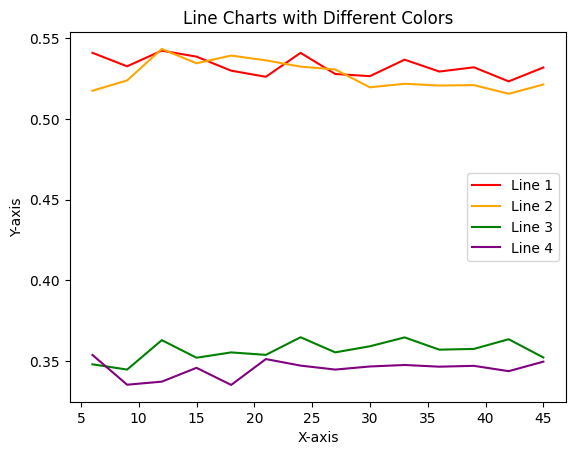

In [ ]:
fig, ax = plt.subplots()
x= [i[0] for i in svd_means_c_1]

# Plot the line charts with different colors
ax.plot(x, [i[1] for i in svd_means_c_1],
        color='red', label='Line 1')
ax.plot(x, [i[1] for i in svd_means_tf_1], color='orange', label='Line 2')
ax.plot(x, [i[1] for i in svd_means_c_2], color='green', label='Line 3')
ax.plot(x, [i[1] for i in svd_means_tf_2], color='purple', label='Line 4')

# Set axis labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Line Charts with Different Colors')
# Add legend
ax.legend()
# Show the plot
plt.show()


## Bertopic

In [ ]:
def advanced_bert(docs, nr_topics=10, min_dist=0.5, n_components=3, vectorizer='count',ngram_range=(2,3), top_n_words=5):
    embedding_model = SentenceTransformer('DeepPavlov/rubert-base-cased-sentence'),
    umap_model = UMAP(n_neighbors=3, n_components=n_components, min_dist=min_dist,random_state=42)
    hdbscan_model = HDBSCAN(min_cluster_size=80, min_samples=40,
                            gen_min_span_tree=True,
                            prediction_data=True)
    
    if vectorizer == 'count':
        vectorizer_model = CountVectorizer(ngram_range=ngram_range)
    
    elif vectorizer == 'tfidf':
        vectorizer_model = TfidfVectorizer(ngram_range=ngram_range)

    model = BERTopic(nr_topics=nr_topics, umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        embedding_model=embedding_model,
        vectorizer_model=vectorizer_model,
        top_n_words=top_n_words,
        language='multilingual',
        calculate_probabilities=True,
        verbose=True)
    
    topics, probs = model.fit_transform(docs)
    return model, topics, probs

In [ ]:
def topic_info_bert(model, topics, docs,df):
  groupedvalues = pd.Series(topics).value_counts().reset_index().sort_values(by='index')
  # распределение топиков
  ax = sns.barplot(groupedvalues ,x='count',y='index', orient='h', palette='Set3')
  for index, row in groupedvalues.iterrows():
      ax.text(row['count'],row['index']+1,row['count'],
              color='black', ha='left',fontweight=549)
  plt.ylabel('Topic')
  plt.show()

  docs_info= model.get_document_info(docs)
  docs_info = docs_info[docs_info.Representative_document == True]
  topics = docs_info.sort_values(by='Topic').Topic.unique()
  topic_dict = model.get_topics()

  for topic in topics[1:]:
    ind = docs_info[docs_info.Topic == topic].index
    print(topic, ' | '.join([word[0] for word in topic_dict[topic]][:5]))
    messages = df.iloc[docs_info[docs_info.Topic ==topic].index].raw_text.values
    for i, msg in enumerate(messages):
      # print(re.sub('\s+',' ',msg)[:200])
      print(i+1, break_string(re.sub('\s+',' ',msg), 100))
    print()

In [ ]:
# https://github.com/MaartenGr/BERTopic/issues/90
# https://stackoverflow.com/questions/70548316/gensim-coherencemodel-gives-valueerror-unable-to-interpret-topic-as-either-a-l
def get_coherence_bert(topic_model, docs, n_top_words=10):
    """Получение средней оценки когерентности"""
    vectorizer = topic_model.vectorizer_model
    X = vectorizer.fit_transform(docs)
    # doc_tokens = [text.split(" ") for text in docs]

    # id2word = corpora.Dictionary(doc_tokens)
    # texts = doc_tokens
    analyzer = vectorizer.build_analyzer()

    tokens = [analyzer(doc) for doc in docs]
    dictionary = corpora.Dictionary(tokens)

    corpus = [dictionary.doc2bow(token) for token in tokens]
    # corpus = [id2word.doc2bow(text) for text in texts]

    topic_words = []
    for i in range(len(topic_model.get_topic_freq())-1):
      interim = []
      interim = [t[0] for t in topic_model.get_topic(i)]
      topic_words.append(interim)

    coherence_model = CoherenceModel(topics=topic_words, texts=tokens, corpus=corpus, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()

    return coherence 

In [ ]:
def bert_compute_best_models(docs,ngram_range=(1, 1), min_df=10,
                             min_topics=10, max_topics=26, step=3):
  bert_means = []
  topic_infos = []

  bert = BERTopic(language="multilingual", calculate_probabilities=True,
                    verbose=True,
                    min_topic_size=30,
                    vectorizer_model=CountVectorizer(ngram_range=ngram_range, min_df=min_df)
                    )
  bert_topics, bert_probs = bert.fit_transform(docs)
  # return bert


  for nr_topics in tqdm_notebook(range(min_topics, max_topics, step)):

    bert_to_reduce = deepcopy(bert)
    bert_to_reduce.reduce_topics(docs, nr_topics=nr_topics)
    coherence = get_coherence_bert(bert_to_reduce, docs)

    bert_means.append([nr_topics, coherence])
    topic_infos.append(bert_to_reduce.get_topic_info())
    del bert_to_reduce

  return bert_means,topic_infos

In [ ]:
def topics_show_bert(
  bert_means, topic_info,n_models=3,keywords=None
  ):
  topic_info_list = list(zip([i[0] for i in bert_means],
                             [i[1] for i in bert_means], 
                              topic_info)
  )
  
  if keywords is None:
    keywords = groupedvalues.Name.apply(lambda x: ' | '.join(x.split('_')[1:]))

  best_models = sorted(topic_info_list, key=lambda x: x[1], reverse=True)[:n_models]

  for topic_table in best_models:
    groupedvalues = topic_table[2]
    plt.figure(figsize=(10,10))
    ax = sns.barplot(x=groupedvalues['Count'],y=groupedvalues.index, orient='h', )
    ax.bar_label(ax.containers[0],
                # labels=groupedvalues.Name
                labels = groupedvalues.Count.astype(str)+ ' ' + keywords
                )
    topic_names = [f'Topic {i}' for i in groupedvalues['Topic']]
    ax.set_yticklabels(topic_names)
    ax.set_frame_on(False)
    plt.xlabel('Count')
    plt.ylabel('Topic')
    plt.title(f'Model with {topic_table[0]} topics')
    plt.show()

# Прогонка моделей

In [ ]:
os.chdir('/content/drive/MyDrive/TM Models')

## LSA

In [ ]:
%%time
svd_models_c_1,svd_means_c_1 = lsa_compute_best_model(cmatrix_1, docs_df_all_1,10, 26, 3)
svd_models_tf_1,svd_means_tf_1 = lsa_compute_best_model(tfmatrix_1, docs_df_all_1,10, 26, 3)
svd_models_c_2,svd_means_c_2 = lsa_compute_best_model(cmatrix_2, docs_df_all_2, 10, 26, 3)
svd_models_tf_2,svd_means_tf_2 = lsa_compute_best_model(tfmatrix_2, docs_df_all_2,10, 26, 3)

CPU times: user 5min 18s, sys: 2min 43s, total: 8min 2s
Wall time: 4min 15s


## sklearn - LDA

In [ ]:
lda_models_c_1, lda_means_c_1 = compute_coherence_values(vec_train_text=cmatrix_1, test_text=docs_df_all_1,
                                                            min_topic=10, max_topic=26, step=3)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
lda_models_tf_1, lda_means_tf_1 = compute_coherence_values(vec_train_text=tfmatrix_1, test_text=docs_df_all_1,
                                                            min_topic=10, max_topic=26, step=3)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
lda_models_c_2, lda_means_c_2 = compute_coherence_values(vec_train_text=cmatrix_2, test_text=docs_df_all_2,
                                                            min_topic=10, max_topic=26, step=3)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
lda_models_tf_2, lda_means_tf_2 = compute_coherence_values(vec_train_text=tfmatrix_2, test_text=docs_df_all_2,
                                                            min_topic=10, max_topic=26, step=3)

  0%|          | 0/6 [00:00<?, ?it/s]

## BERTopic 

In [ ]:
bert_means_1,topic_infos_1 = bert_compute_best_models(docs_df_all_1, 
                             min_topics=10, max_topics=26, step=3)

Batches:   0%|          | 0/605 [00:00<?, ?it/s]

2023-05-29 01:19:05,541 - BERTopic - Transformed documents to Embeddings
2023-05-29 01:19:19,762 - BERTopic - Reduced dimensionality
2023-05-29 01:19:24,622 - BERTopic - Clustered reduced embeddings


  0%|          | 0/6 [00:00<?, ?it/s]

2023-05-29 01:19:31,598 - BERTopic - Reduced number of topics from 65 to 10
2023-05-29 01:19:38,871 - BERTopic - Reduced number of topics from 65 to 13
2023-05-29 01:19:46,006 - BERTopic - Reduced number of topics from 65 to 16
2023-05-29 01:19:52,743 - BERTopic - Reduced number of topics from 65 to 19
2023-05-29 01:20:01,142 - BERTopic - Reduced number of topics from 65 to 22
2023-05-29 01:20:08,318 - BERTopic - Reduced number of topics from 65 to 25


In [ ]:
bert_means_2,topic_infos_2 = bert_compute_best_models(docs_df_all_1, 
                                           min_df=2, ngram_range=(2, 2), 
                             min_topics=10, max_topics=26, step=3)

Batches:   0%|          | 0/605 [00:00<?, ?it/s]

2023-05-29 01:49:30,204 - BERTopic - Transformed documents to Embeddings
2023-05-29 01:49:44,453 - BERTopic - Reduced dimensionality
2023-05-29 01:49:51,276 - BERTopic - Clustered reduced embeddings


  0%|          | 0/6 [00:00<?, ?it/s]

2023-05-29 01:50:01,212 - BERTopic - Reduced number of topics from 69 to 10
2023-05-29 01:50:11,120 - BERTopic - Reduced number of topics from 69 to 13
2023-05-29 01:50:21,471 - BERTopic - Reduced number of topics from 69 to 16
2023-05-29 01:50:32,751 - BERTopic - Reduced number of topics from 69 to 19
2023-05-29 01:50:42,931 - BERTopic - Reduced number of topics from 69 to 22
2023-05-29 01:50:53,562 - BERTopic - Reduced number of topics from 69 to 25


In [ ]:
topics_show_bert(bert_means_1,topic_infos_1)

In [ ]:
topics_show_bert(bert_means_2,topic_infos_2)

### archieve

In [ ]:
# bert_c_1 = BERTopic(language="multilingual", calculate_probabilities=True,
#                        verbose=True,min_topic_size=20, nr_topics=20,
#                        vectorizer_model=CountVectorizer(ngram_range=(1, 1), min_df=15))
# bert_topics_c_1, bert_probs_c_1 = bert_c_1.fit_transform(docs_df_all_1)
# coherence = get_coherence_bert(bert_c_1, docs_df_all_1)
# coherence

Batches:   0%|          | 0/605 [00:00<?, ?it/s]

2023-05-29 00:39:42,444 - BERTopic - Transformed documents to Embeddings
2023-05-29 00:39:57,079 - BERTopic - Reduced dimensionality
2023-05-29 00:40:05,537 - BERTopic - Clustered reduced embeddings


0.5158629283038592

In [ ]:
# docs_df_all_1

In [ ]:
# topic_model_df_all_1.visualize_topics()

In [ ]:
# topic_model_df_all_1.visualize_hierarchy(top_n_topics=50, width=800)

In [ ]:
# topic_model_df_all_1.visualize_barchart(top_n_topics=20)

Биграммы

In [ ]:
# topic_model_df_all_2 = BERTopic(language="multilingual", calculate_probabilities=True,
#                        verbose=True)
# topics_df_all_2, probs_df_all_2 = topic_model_df_all_2.fit_transform(docs_df_all_2)

Batches:   0%|          | 0/605 [00:00<?, ?it/s]

2023-05-28 05:17:54,113 - BERTopic - Transformed documents to Embeddings
2023-05-28 05:18:08,273 - BERTopic - Reduced dimensionality
2023-05-28 05:18:27,321 - BERTopic - Clustered reduced embeddings


In [ ]:
# topic_model_tg_2.save('/content/drive/MyDrive/TM Models/topics_df_all_2')

In [ ]:
for i,j in topic_model_df_all_2.get_topic_info().head(50)[['Count','Name']].iterrows():
  print(j.Count, j.Name)

10152 -1_раздельный_сбор_окружать_среда_пункт_приём_пищевой_отход
1353 0_пластиковый_пакет_пластиковый_бутылка_пластиковый_упаковка_пластик_стекло
625 1_детский_сад_детский_площадка_ребёнок_школа_родитель_ребёнок
602 2_открыть_магазин_товар_упаковка_продавать_товар_интернет_магазин
347 3_твёрдый_шампунь_мытьё_посуда_жидкий_мыло_хозяйственный_мыло
338 4_сбор_мусор_пищевой_отход_раздельный_сбор_сортировать_мусор
318 5_старый_одежда_натуральный_кожа_натуральный_ткань_постельный_бельё
294 6_русский_язык_российский_федерация_комитет_российский_государственный_дума
245 7_точка_зрение_искусственный_интеллект_когото_переубедить_отношение_вещь
193 8_овощ_фрукт_фрукт_овощ_стоить_хранить_мыльный_дерево
179 9_пить_кофе_выпить_кофе_брать_кофе_одноразовый_стакан
177 10_кошка_собака_кошка_улица_собака_приют_домашний_питомец
144 11_покупать_вода_чистый_вода_ливневый_канализация_вода_канализация
118 12_смотреть_видео_видео_тема_ролик_девушка_видео_ролик
118 13_новогодний_праздник_покупать_подарок_подар

In [ ]:
topic_model_df_all_2.visualize_topics()

100%|██████████| 146/146 [00:01<00:00, 83.19it/s]


In [ ]:
hierarchical_topics_all_2 = topic_model_df_all_2.hierarchical_topics(docs_df_all_2)
topic_model_df_all_2.visualize_hierarchy(hierarchical_topics=hierarchical_topics_all_2)

In [ ]:
tree_all_2 = topic_model_df_all_2.get_topic_tree(hierarchical_topics_all_2)
print(tree_all_2)

.
├─изделие_конструкция_материал_изделие_строительный_материал_объём_свалка_конструкция_образоваться
│    ├─■──свалка_тбо_объём_свалка_поэлементный_демонтаж_строительный_технология_сотня_различный ── Topic: 120
│    └─■──конструкция_образоваться_изделие_конструкция_материал_изделие_использование_строительный_система_пов ── Topic: 126
└─раздельный_сбор_окружать_среда_пластиковый_бутылка_пластиковый_пакет_сбор_мусор
     ├─раздельный_сбор_пластиковый_бутылка_пластиковый_пакет_пластиковый_упаковка_сбор_мусор
     │    ├─движение_раздельный_раздельный_сбор_общий_чат_чат_движение_пожаловать_общий
     │    │    ├─■──общий_чат_обсуждить_вопрос_задать_обсуждить_пожаловать_общий_чат_движение ── Topic: 16
     │    │    └─■──движение_раздельный_проект_собиратор_сбор_проект_раздельный_сбор_местный_группа ── Topic: 89
     │    └─пластиковый_бутылка_пластиковый_пакет_раздельный_сбор_пластиковый_упаковка_сбор_мусор
     │         ├─пластиковый_бутылка_пластиковый_пакет_раздельный_сбор_пластиковый_

In [ ]:
topic_model_df_all_2.visualize_heatmap()

In [ ]:
topic_model_df_all_2.visualize_term_rank()

In [ ]:
topic_model_df_all_2.visualize_term_rank()
topic_model_df_all_2.visualize_barchart(top_n_topics=20)

In [ ]:
pd.Series(topics_df_all_2).value_counts()[:20]

In [ ]:
topic_info_bert(topic_model_df_all_2,topics_df_all_2,docs_df_all_2,df_all)

#### reduction

In [ ]:
topic_model_df_all_2_red = deepcopy(topic_model_df_all_2)

In [ ]:
topic_model_df_all_2_red.reduce_topics(docs_df_all_2, nr_topics=20)

2023-05-28 05:45:04,662 - BERTopic - Reduced number of topics from 148 to 20


In [ ]:
# topic_model_df_all_2_red.save('/content/drive/MyDrive/TM Models/topic_model_df_all_2_red')

In [ ]:
topics_df_all_2_red =  topic_model_df_all_2_red.get_document_info(docs_df_all_2).Topic.tolist()

In [ ]:
topic_model_df_all_2_red.visualize_topics()

In [ ]:
hierarchical_topics_all_2_red = topic_model_df_all_2_red.hierarchical_topics(docs_df_all_2)

100%|██████████| 18/18 [00:00<00:00, 71.71it/s]


In [ ]:
topic_model_df_all_2_red.visualize_hierarchy(hierarchical_topics=hierarchical_topics_all_2_red)

In [ ]:
tree_all_2_red = topic_model_df_all_2_red.get_topic_tree(hierarchical_topics_all_2_red)
print(tree_all_2_red)

.
├─раздельный_сбор_окружать_среда_пластиковый_бутылка_пластиковый_пакет_пищевой_отход
│    ├─■──овощ_фрукт_растительный_молоко_кокосовый_масло_фрукт_овощ_покупать_молоко ── Topic: 3
│    └─раздельный_сбор_окружать_среда_пластиковый_бутылка_пластиковый_пакет_сбор_мусор
│         ├─раздельный_сбор_окружать_среда_пластиковый_бутылка_пластиковый_пакет_пищевой_отход
│         │    ├─■──пластиковый_пакет_пластиковый_бутылка_пластиковый_упаковка_пластик_стекло_раздельный_сбор ── Topic: 1
│         │    └─■──раздельный_сбор_окружать_среда_зелёный_бык_старый_одежда_твёрдый_шампунь ── Topic: 0
│         └─■──детский_сад_детский_площадка_ребёнок_школа_родитель_ребёнок_ребёнок_ребёнок ── Topic: 2
└─христианский_традиция_изменение_климат_глобальный_потепление_углеродный_след_менструальный_чаша
     ├─христианский_традиция_изменение_климат_углеродный_след_глобальный_потепление_общественный_транспорт
     │    ├─изменение_климат_углеродный_след_глобальный_потепление_общественный_транспорт_парниковый

In [ ]:
topic_model_df_all_2_red.visualize_barchart(top_n_topics=20)

In [ ]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model_df_all_2_red.approximate_distribution(docs_df_all_2, calculate_tokens=True)

# Visualize the token-level distributions
qq = topic_model_df_all_2_red.visualize_approximate_distribution(docs_df_all_2[1], topic_token_distr[1])
qq

In [ ]:
topic_model_df_all_2_red.visualize_term_rank()

### Анализ топиков

In [ ]:
def vectorizer(df, ngram_range=(1,1), min_df=5, mode='c'):
  if mode == 'c':
      cvect = CountVectorizer(ngram_range=ngram_range,min_df=min_df).fit(df['text_space'])
      cmatrix = cvect.transform(df['text_space'])
      cmatrix = pd.DataFrame(cmatrix.toarray(), columns = cvect.get_feature_names_out(), index=df.index)
      return cvect, cmatrix

  elif mode == 'tf':
      tfidfvect = TfidfVectorizer(ngram_range=ngram_range,min_df=min_df).fit(df['text_space'])
      tfidfmatrix = tfidfvect.transform(df['text_space'])
      tfidfmatrix = pd.DataFrame(tfidfmatrix.toarray(), columns = tfidfvect.get_feature_names_out(), index=df.index)

      return  tfidfvect, tfidfmatrix


In [ ]:
topic_model_df_all_2_red.get_topic(-1)

In [ ]:
docs_info.to_excel('docs_info_bert.xlsx')

In [ ]:
topic = -1
docs_info= topic_model_df_all_2_red.get_document_info(docs_df_all_2)
docs_topic = docs_info[docs_info.Topic == topic].sort_values(by='Probability', ascending=False)
ind = docs_topic.index

# print(topic, ' | '.join([word[0] for word in topic_dict[topic]][:5]))
messages = df_all.iloc[ind].raw_text.values[:10]
for i, msg in enumerate(messages):
  # print(re.sub('\s+',' ',msg)[:200])
  print(i+1, break_string(re.sub('\s+',' ',msg), 100))
print()

In [ ]:
topic_minus_1

In [ ]:
# df_all[pd.Series(topics_df_all_2_red) == 1].head(10).raw_text.values

In [ ]:
topic_info_bert(topic_model_df_all_2_red,topics_df_all_2_red,docs_df_all_2,df_all)

In [ ]:
topic_minus_1 = df_all.iloc[ind]

In [ ]:
min_1_cvect_2, min_1_cmatrix_2 =  vectorizer(topic_minus_1, ngram_range=(2,2), min_df=10, mode='c')
min_1_cvect_1, min_1_cmatrix_1 =  vectorizer(topic_minus_1, ngram_range=(1,1), min_df=10, mode='c')

In [ ]:
min_1_cmatrix_2

In [ ]:
def freq_vis(matrix, ):
  matrix_sum = matrix.sum(axis=0);
  groupedvalues = matrix_sum.sort_values(ascending=False).head(20).reset_index()
  groupedvalues.rename(columns={0:'Частота', 'index':'Токен'},inplace=True)
  plt.figure(figsize=(6,8))
  ax =sns.barplot(groupedvalues, x='Частота', y='Токен')
  for index, row in groupedvalues.iterrows():
      ax.text(row['Частота'],row.name,row['Частота'],
              color='black', ha='center',fontweight=450)

  plt.show()

In [ ]:
freq_vis(min_1_cmatrix_1)

In [ ]:
freq_vis(min_1_cmatrix_2)

# Сравнение моделей

In [ ]:
fig, ax = plt.subplots()
x= [i[0] for i in svd_means_c_1]

# Plot the line charts with different colors
ax.plot(x, [i[1] for i in svd_means_c_1],
        color='red', label='LSA')
ax.plot(x, lda_means_c_1, 
        color='orange', label='LDA')
ax.plot(x, [i[1] for i in bert_means_1] , color='blue', label='BERT')
# ax.plot(x, lda_means_tf_1, color='purple', label='TfidfVec LDA')

# Set axis labels and title
ax.set_xlabel('Topics')
ax.set_ylabel('Coherence Score')
ax.set_title('LSA-LDA-BERT Comparison 1-gram')
# Add legend
ax.legend()
# Show the plot
plt.show()

In [ ]:
fig, ax = plt.subplots()
x= [i[0] for i in svd_means_c_1]

# Plot the line charts with different colors
ax.plot(x, [i[1] for i in svd_means_c_2],
        color='red', label='LSA')
ax.plot(x, lda_means_c_2, 
        color='orange', label='LDA')
ax.plot(x, [i[1] for i in bert_means_2] , color='blue', label='BERT')
# ax.plot(x, lda_means_tf_1, color='purple', label='TfidfVec LDA')

# Set axis labels and title
ax.set_xlabel('Topics')
ax.set_ylabel('Coherence Score')
ax.set_title('LSA-LDA-BERT Comparison 2-gram')
# Add legend
ax.legend()
# Show the plot
plt.show()

In [ ]:
topics_show_lsa(
    svd_models_c_1,svd_means_c_1,
    cvect_1, cmatrix_1,
    n_models=3)

In [ ]:
topics_show_lsa(
    svd_models_c_2,svd_means_c_2,
    cvect_2, cmatrix_2,
    n_models=3)

In [ ]:
topics_show_lda(
    lda_models_c_1, lda_means_c_1,
    cvect_1, cmatrix_1,
    n_models=3)

In [ ]:
topics_show_lda(
    lda_models_c_2, lda_means_c_2,
    cvect_2, cmatrix_2,
    n_models=3)

In [ ]:
topics_show_bert(bert_means_1,topic_infos_1)

In [ ]:
topics_show_bert(bert_means_2,topic_infos_2)

# Первичный  Анализ топиков (BERT)

In [ ]:
# umap_model = UMAP(n_neighbors=3, n_components=25, min_dist=0.05,random_state=42)
# hdbscan_model = HDBSCAN(min_cluster_size=50, min_samples=40,
#                         gen_min_span_tree=True,
#                         prediction_data=True)

In [ ]:
def split(s):
  split_s = s.split('_')[1:]
  result = ['_'.join(split_s[i:i+2]).replace('_', ' ') for i in range(0, len(split_s), 2)]
  return ' | '.join(result)

In [ ]:
# bert_initial = BERTopic(language="multilingual", calculate_probabilities=True,
#                        verbose=True, 
#                         umap_model=umap_model,
#                         hdbscan_model=hdbscan_model,
#                         nr_topics=25,
#                        vectorizer_model=CountVectorizer(ngram_range=(1, 1))
#                        )
# bert_topics_initial, bert_probs_initial = bert_initial.fit_transform(docs_df_all_2)
# coherence = get_coherence_bert(bert_initial, docs_df_all_2)
# coherence

Batches:   0%|          | 0/605 [00:00<?, ?it/s]

2023-05-29 05:37:43,789 - BERTopic - Transformed documents to Embeddings
2023-05-29 05:38:00,843 - BERTopic - Reduced dimensionality
2023-05-29 05:38:21,058 - BERTopic - Clustered reduced embeddings
2023-05-29 05:38:28,788 - BERTopic - Reduced number of topics from 145 to 25


0.371540924871768

In [ ]:
bert_initial.save('/content/drive/MyDrive/TM Models/bert_initial')

In [681]:
from wordcloud import WordCloud

In [682]:
def create_wordcloud(topic_model, topic):
    text = {word: value for word, value in topic_model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

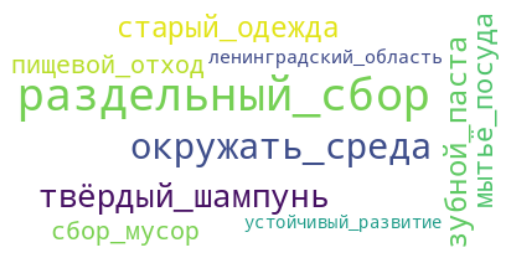

In [683]:
create_wordcloud(bert_initial, topic=0)

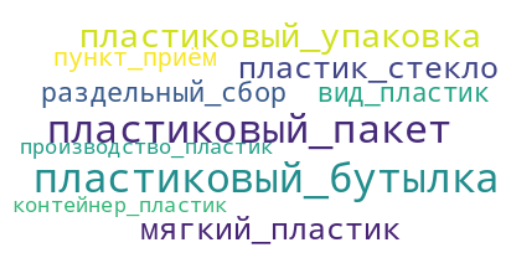

In [684]:
create_wordcloud(bert_initial, topic=1)

In [ ]:
create_wordcloud(bert_initial, topic=1)

In [ ]:
bert_initial_topics = bert_initial.get_topic_info()
bert_initial_topics.Name = +bert_initial_topics.Name.apply(split)
bert_initial_topics

In [ ]:
topics_show_bert([[25,2]],[bert_initial_topics], keywords=bert_initial_topics.Name)

In [ ]:
bert_initial.visualize_topics()

In [ ]:
bert_initial.visualize_heatmap()

<Axes: >

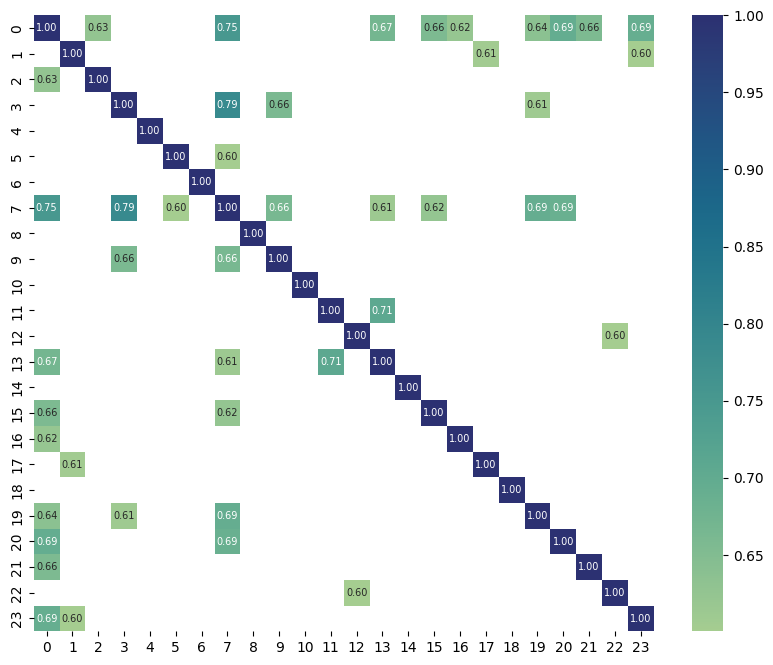

In [ ]:
plt.figure(figsize=(10,8))
matrix = bert_initial.visualize_heatmap().data[0].z
sns.heatmap(matrix, annot=True, mask=matrix<0.6, fmt=".2f", cmap="crest",
            annot_kws={"fontsize":7})

In [ ]:
bert_initial.visualize_barchart(top_n_topics=25)

In [ ]:
topic =-1
pd.DataFrame(bert_initial.get_topic(topic), columns = ['Топики', 'Частота']).set_index('Топики')

,Частота
Топики,
раздельный_сбор,0.004192
окружать_среда,0.002812
пищевой_отход,0.001785
пункт_приём,0.001516
точка_зрение,0.001458
бытовой_химия,0.001343
сдать_переработка,0.001237
пластиковый_бутылка,0.001192
больший_часть,0.001116


In [ ]:
docs_info= bert_initial.get_document_info(docs_df_all_2)
docs_topic = docs_info[docs_info.Topic == topic].sort_values(by='Probability', ascending=False)
ind = docs_topic.index

# print(topic, ' | '.join([word[0] for word in topic_dict[topic]][:5]))
messages = df_all.iloc[ind].query('length < 50').head(50).raw_text.values
pd.DataFrame(messages)
# for i, msg in enumerate(messages):
#   # print(re.sub('\s+',' ',msg)[:200])
#   print(i+1, break_string(re.sub('\s+',' ',msg), 100))
 # print()

In [ ]:
bert_topics_info =  pd.concat([
    df_all[['raw_text', 'source', 'text', 'text_space']].reset_index(drop=True),
    docs_info[['Topic', 'Probability']]
],axis=1,ignore_index=True)

In [ ]:
bert_topics_info.to_excel('bert_topics_info.xlsx')

In [ ]:
df_all[['raw_text', 'source', 'text', 'text_space']].reset_index(drop=True)

,raw_text,source,text,text_space
0,Альтернатива живым цветам - натуральные цветоч...,vsemvermi_messages,"[альтернатива, живой, цвет, натуральный, цвето...",альтернатива живой цвет натуральный цветочный ...
1,Альтернатива к цветам - Эко свечи ручной работ...,vsemvermi_messages,"[альтернатива, цвет, свеча, ручной, работа, бо...",альтернатива цвет свеча ручной работа божестве...
2,Альтернатива цветам - сладкий подарок-открытка...,vsemvermi_messages,"[альтернатива, цвет, сладкий, подарокоткрытка,...",альтернатива цвет сладкий подарокоткрытка бент...
3,Свечи из натурального соевого воска ✨️\n\nПода...,vsemvermi_messages,"[свеча, натуральный, соевый, воск, подарочный,...",свеча натуральный соевый воск подарочный оформ...
4,"Мыльные наборы с натуральным составом, алоэ ве...",vsemvermi_messages,"[мыльный, набор, натуральный, состав, алоэ, ве...",мыльный набор натуральный состав алоэ вера увл...
...,...,...,...,...
19333,Вы можете присоединиться к другим близлежащих ...,tg_sobirator_messages,"[присоединиться, другим, близлежащих, район, с...",присоединиться другим близлежащих район создат...
19334,Добрый вечер! Есть ли тут люди/отдельный чат п...,tg_sobirator_messages,"[добрый, вечер, людиотдельный, чат, попутчик, ...",добрый вечер людиотдельный чат попутчик мтреть...
19335,Всем привет! Мы создали чат единомышленников в...,tg_sobirator_messages,"[привет, создать, чат, единомышленник, волонтё...",привет создать чат единомышленник волонтёр про...
19336,♻️ГРУППЫ ПО РАЙОНАМ!♻️\n----------------------...,tg_sobirator_messages,"[группа, район, обсуждение, связать, попутчик,...",группа район обсуждение связать попутчик марьи...


In [ ]:
df_all.shape

(19338, 8)

# анализ больших топиков

In [ ]:
topic = 0
docs_info= bert_initial.get_document_info(docs_df_all_2)
docs_topic = docs_info[docs_info.Topic == topic].sort_values(by='Probability', ascending=False)
ind = docs_topic.index
messages_of_topic = df_all.iloc[ind]

In [ ]:
bert_0 = BERTopic(language="multilingual", calculate_probabilities=True,
                       verbose=True, 
                        nr_topics=25,
                       vectorizer_model=CountVectorizer(ngram_range=(1, 1))
                       )
docs_topic = messages_of_topic['2_grams_space'].to_list()
bert_topics_initial, bert_probs_initial = bert_0.fit_transform(docs_topic)
coherence = get_coherence_bert(bert_0, docs_topic)
coherence

Batches:   0%|          | 0/316 [00:00<?, ?it/s]

2023-05-29 07:27:44,672 - BERTopic - Transformed documents to Embeddings
2023-05-29 07:27:57,756 - BERTopic - Reduced dimensionality
2023-05-29 07:28:02,147 - BERTopic - Clustered reduced embeddings
2023-05-29 07:28:05,728 - BERTopic - Reduced number of topics from 94 to 25


0.31587091956568164

In [ ]:
bert_0.visualize_barchart(top_n_topics=25)

In [ ]:
topic = 1
docs_info= bert_initial.get_document_info(docs_df_all_2)
docs_topic = docs_info[docs_info.Topic == topic].sort_values(by='Probability', ascending=False)
ind = docs_topic.index
messages_of_topic = df_all.iloc[ind]
bert_1 = BERTopic(language="multilingual", calculate_probabilities=True,
                       verbose=True, 
                        nr_topics=25,
                       vectorizer_model=CountVectorizer(ngram_range=(1, 1))
                       )
docs_topic = messages_of_topic['2_grams_space'].to_list()
bert_topics_initial, bert_probs_initial = bert_1.fit_transform(docs_topic)
coherence = get_coherence_bert(bert_1, docs_topic)
coherence

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

2023-05-29 07:28:27,148 - BERTopic - Transformed documents to Embeddings
2023-05-29 07:28:32,269 - BERTopic - Reduced dimensionality
2023-05-29 07:28:32,355 - BERTopic - Clustered reduced embeddings
2023-05-29 07:28:32,590 - BERTopic - Reduced number of topics from 14 to 14


0.3918943767679153

In [ ]:
bert_1.visualize_barchart(top_n_topics=25)

In [ ]:
bert_topics_0 = bert_0.get_topic_info()
bert_topics_0.Name = bert_topics_0.Name.apply(split)
bert_topics_0

,Topic,Count,Name
0,-1,7042,раздельный сбор | окружать среда | пищевой отх...
1,0,1384,раздельный сбор | окружать среда | ноль отход ...
2,1,333,пластиковый пакет | бумажный пакет | пластиков...
3,2,308,окружать среда | устойчивый развитие | экологи...
4,3,232,ленинградский область | финский залив | невски...
5,4,121,чайный ложка | столовый ложка | восковой салфе...
6,5,79,час земля | окружать среда | дикий природа | п...
7,6,72,органический отход | пищевой отход | мусорный ...
8,7,59,контейнерный площадка | новый контейнер | разд...
9,8,51,солнечный батарея | солнечный панель | добыча ...


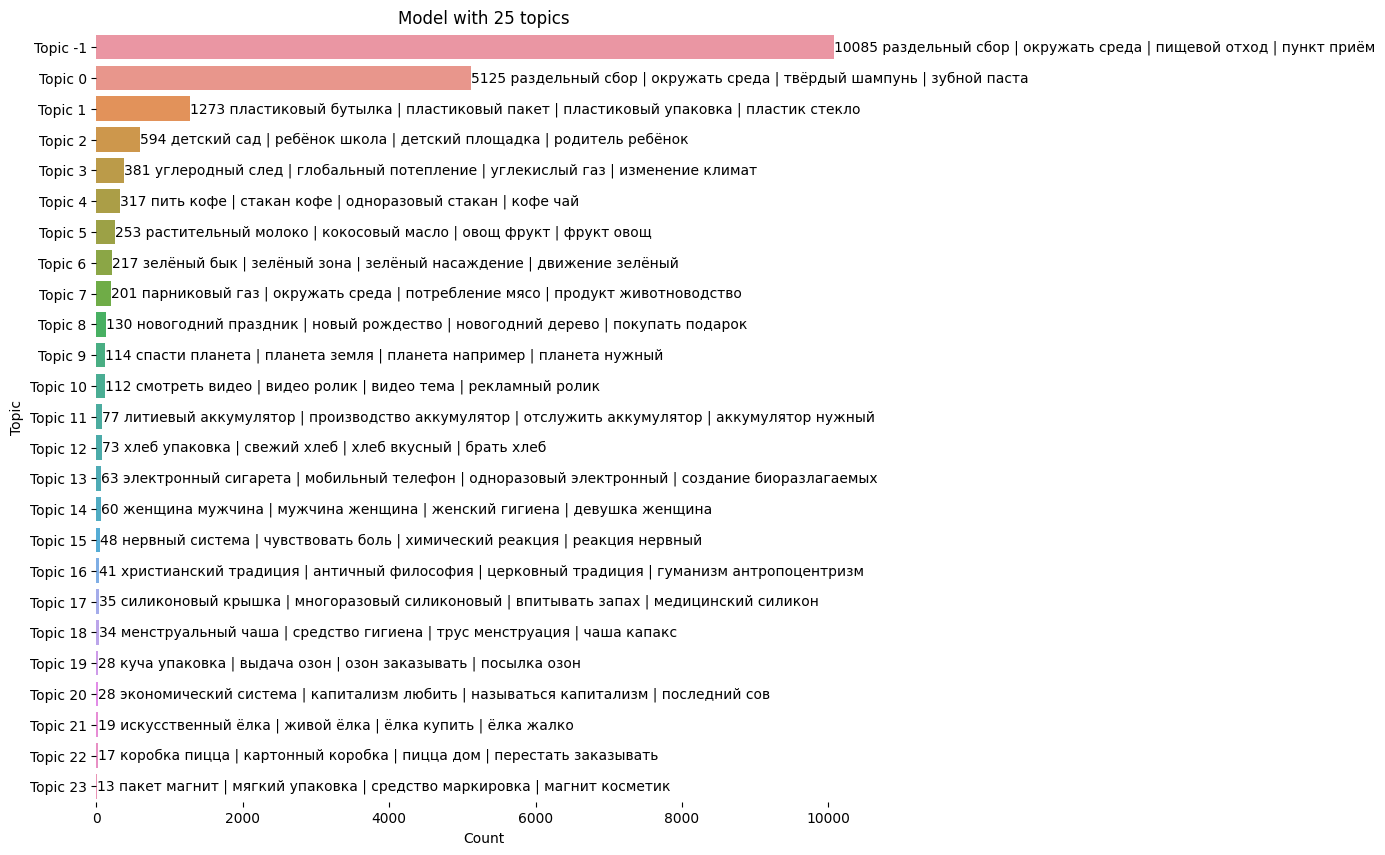

In [ ]:
topics_show_bert([[25,2]],[bert_initial_topics], keywords=bert_initial_topics.Name)

In [ ]:
topic = -1
docs_info= bert_initial.get_document_info(docs_df_all_2)
docs_topic = docs_info[docs_info.Topic == topic].sort_values(by='Probability', ascending=False)
ind = docs_topic.index
messages_of_topic = df_all.iloc[ind]

bert_min_1 = BERTopic(language="multilingual", calculate_probabilities=True,
                       verbose=True, 
                        nr_topics='auto',
                       vectorizer_model=CountVectorizer(ngram_range=(1, 1))
                       )
docs_topic = messages_of_topic['2_grams_space'].to_list()
bert_topics_initial, bert_probs_initial = bert_min_1.fit_transform(docs_topic)
coherence = get_coherence_bert(bert_min_1, docs_topic)
coherence

Batches:   0%|          | 0/316 [00:00<?, ?it/s]

2023-05-29 07:19:11,686 - BERTopic - Transformed documents to Embeddings
2023-05-29 07:19:19,351 - BERTopic - Reduced dimensionality
2023-05-29 07:19:20,397 - BERTopic - Clustered reduced embeddings
2023-05-29 07:19:23,425 - BERTopic - Reduced number of topics from 3 to 3


0.28352932890291715

In [ ]:
bert_topics_initial

In [ ]:
bert_min_1.visualize_barchart(top_n_topics=25)

In [ ]:
bert_min_1.get_topic_info()

,Topic,Count,Name
0,-1,477,-1_экологический_проблема_раздельный_сбор_окру...
1,0,9595,0_раздельный_сбор_окружать_среда_пищевой_отход...
2,1,13,1_чистый_игра_участие_игра_играть_игра_бесплат...


# 

# Setiment analysis

In [ ]:
topic_sent = pd.read_excel('topics_sentiment.xlsx')
topic_sent.text = topic_sent.text.apply(lambda x: str_to_list(x))
topic_sent.rename(columns={'Max_Column': 'sentiment'}, inplace=True)
topic_sent

In [582]:
topic_pos = topic_sent[(topic_sent.sentiment=='positive')]
topic_neg = topic_sent[(topic_sent.sentiment=='negative')]
topic_pos.shape, topic_neg.shape

((794, 12), (3313, 12))

In [ ]:
plt.figure(figsize=(4,3))
gg = topic_sent.sentiment.value_counts().reset_index()
ax = sns.barplot(gg ,x='count',y='sentiment', orient='h',)
ax.bar_label(ax.containers[0])
ax.set_frame_on(False)
plt.xlabel('Count')
plt.ylabel('Sentiment')
plt.title(f'Distribution of sentiment in whole dataset')
plt.show()

In [641]:
cvect_1_pos, cmatrix_1_pos = vectorizer(topic_sent.query('sentiment == "positive"'), ngram_range=(1,1),min_df=0, mode='c')
cvect_2_pos, cmatrix_2_pos = vectorizer(topic_sent.query('sentiment == "positive"'), ngram_range=(2,2),min_df=0, mode='c')
cvect_1_neg, cmatrix_1_neg = vectorizer(topic_sent.query('sentiment == "negative"'), ngram_range=(1,1),min_df=0, mode='c')
cvect_2_neg, cmatrix_2_neg = vectorizer(topic_sent.query('sentiment == "negative"'), ngram_range=(2,2),min_df=0, mode='c')

In [ ]:
freq_vis(cmatrix_1_pos)

In [ ]:
freq_vis(cmatrix_1_neg)

In [ ]:
freq_vis(cmatrix_2_pos)

In [613]:
def dist_sent(topic):
  plt.figure(figsize=(4,3))
  topic_sent_un = topic_sent[topic_sent.topic == topic]
  gg = topic_sent_un.sentiment.value_counts().reset_index()
  ax = sns.barplot(gg ,x='count',y='sentiment', orient='h',)
  ax.bar_label(ax.containers[0])
  ax.set_frame_on(False)
  plt.xlabel('Count')
  plt.ylabel('Sentiment')
  plt.title(f'Distribution of sentiment in topic {topic}')
  plt.show()
  

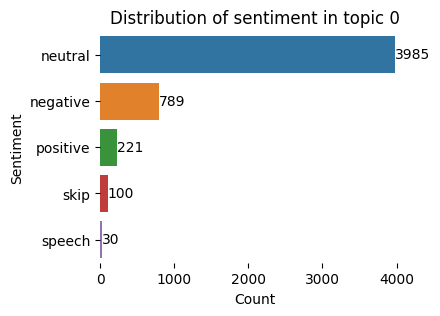

In [677]:
dist_sent(0)

In [668]:
topic = 0

In [ ]:
topic_sent_un = topic_sent[topic_sent.topic == topic]

messages = topic_sent_un.query('sentiment == "positive"').sort_values(by='positive', ascending=False).raw_text.values
pd.DataFrame(messages)

In [673]:
topic_sent_un = topic_sent[topic_sent.topic == topic]
messages = topic_sent_un.query('sentiment == "neutral"').sort_values(by='neutral', ascending=False).raw_text.values[:50]
pd.DataFrame(messages)

,0
0,"[id204864863|Тики], посчитать ""ударность"" дозы..."
1,Периодически появляются много картриджей от пр...
2,"Прошла по ссылке, авторизовались через ЕСИА, а..."
3,"Подскажите, где может работать выпускник напра..."
4,"Что, выбрасывание мусора? Регулируется. Можете..."
5,Уважаемые коллеги! Вопросы в комментариях треб...
6,"Формат форума - онлайн в ZOOM, у вас будет воз..."
7,Эта акция учитывает принцип Repair&Reuse? На ...
8,Заходите и голосуйте на сайте Российских общес...
9,"Подскажите, мусор который мы ""сортируем"" выбра..."


In [676]:
topic_sent_un = topic_sent[topic_sent.topic == topic]
messages = topic_sent_un.query('sentiment == "negative"').head(50).sort_values(by='negative', ascending=False).raw_text.values
pd.DataFrame(messages)

,0
0,А по-моему просто слишком уж много пофигистов ...
1,"Для меня носить многоразовую бутылку, термокру..."
2,"[id25909604|Татьяна], у меня тоже кошка с удов..."
3,"А у нас в городе,в моём районе, нет контейнеро..."
4,"[id423076402|Павел], тут Вы абсолютно правы. Т..."
5,"[id186741626|Julia], легче сдохнуть, чтобы воо..."
6,Это ещё весьма лояльное отношение со стороны м...
7,Всё!!!! Больше не могу копить в морозилке орга...
8,"Не понимаю, в чем недовольства. Человек попыта..."
9,Добрый день. А если ее не мыть и просто остави...


In [635]:
def freq_vis(matrix, ):
  matrix_sum = matrix.sum(axis=0);
  groupedvalues = matrix_sum.sort_values(ascending=False).head(20).reset_index()
  groupedvalues.rename(columns={0:'Частота', 'index':'Токен'},inplace=True)
  plt.figure(figsize=(6,8))
  ax =sns.barplot(groupedvalues, x='Частота', y='Токен')
  for index, row in groupedvalues.iterrows():
      ax.text(row['Частота'],row.name,row['Частота'],
              color='black', ha='center',fontweight=450)

  plt.show()

In [634]:
cvect_1_pos, cmatrix_1_pos = vectorizer(topic_sent_un.query('sentiment == "positive"'), ngram_range=(1,1),min_df=0, mode='c')
cvect_2_pos, cmatrix_2_pos = vectorizer(topic_sent_un.query('sentiment == "positive"'), ngram_range=(2,2),min_df=0, mode='c')

In [660]:
cvect_1_neg, cmatrix_1_neg = vectorizer(topic_sent_un.query('sentiment == "negative"'), ngram_range=(1,1),min_df=0, mode='c')
cvect_2_neg, cmatrix_2_neg = vectorizer(topic_sent_un.query('sentiment == "negative"'), ngram_range=(2,2),min_df=0, mode='c')

In [665]:
cvect_1_ntr, cmatrix_1_ntr = vectorizer(topic_sent_un.query('sentiment == "neutral"'), ngram_range=(1,1),min_df=0, mode='c')
cvect_2_ntr, cmatrix_2_ntr = vectorizer(topic_sent_un.query('sentiment == "neutral"'), ngram_range=(2,2),min_df=0, mode='c')

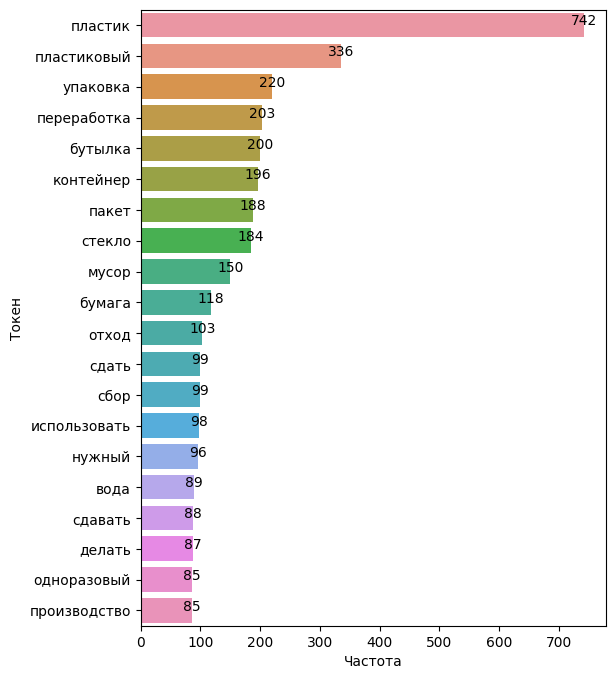

In [666]:
freq_vis(cmatrix_1_ntr)

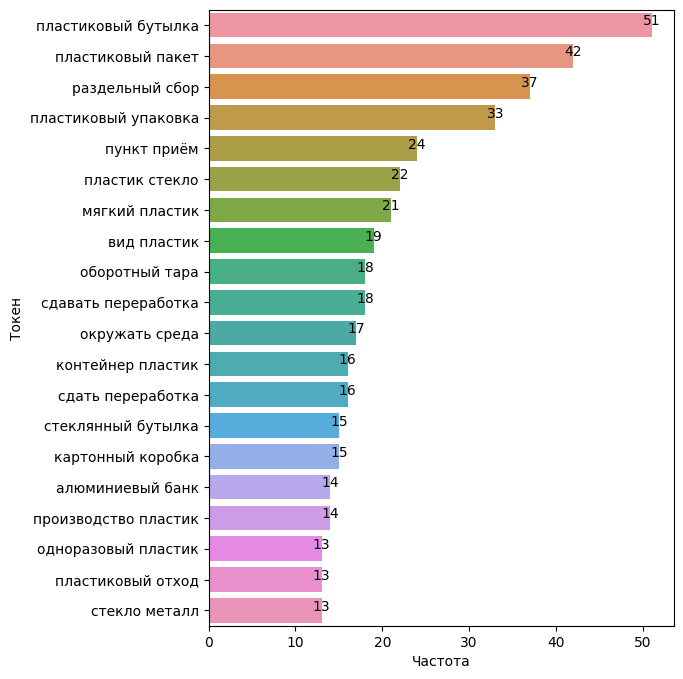

In [667]:
freq_vis(cmatrix_2_ntr)

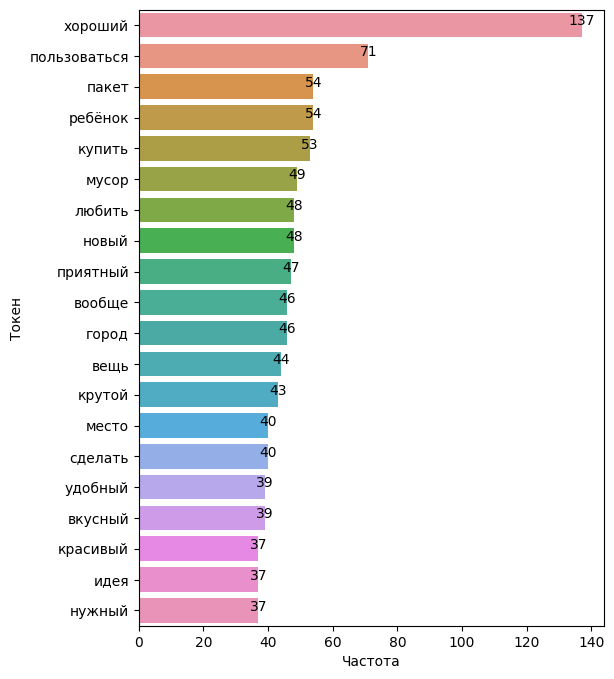

In [663]:
freq_vis(cmatrix_1_pos)

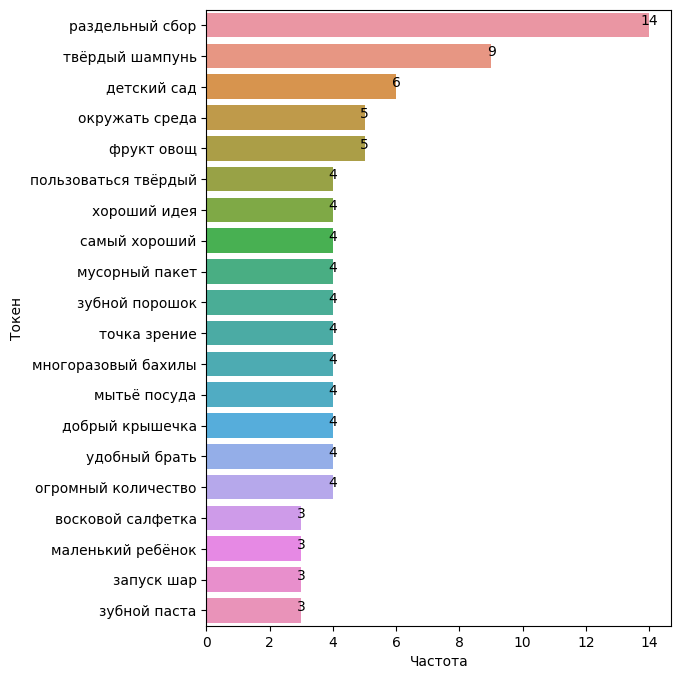

In [664]:
freq_vis(cmatrix_2_pos)

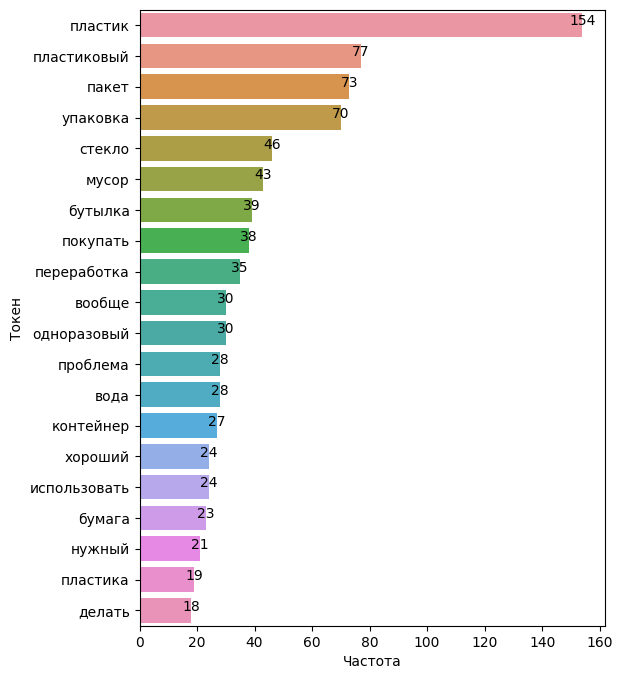

In [662]:
freq_vis(cmatrix_1_neg)

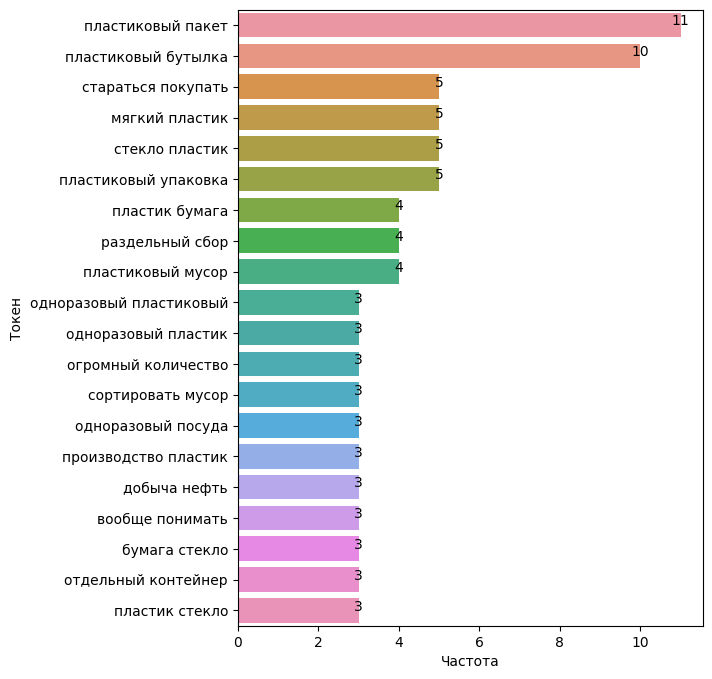

In [661]:
freq_vis(cmatrix_2_neg)

In [ ]:
topic_sent[(topic_sent.topic==0) & (topic_sent.Max_Column=='positive')].sort_values(by='Probability', ascending=False).raw_text.values

In [ ]:
topic_sent[(topic_sent.topic==1) & (topic_sent.Max_Column=='positive')].raw_text.values

In [ ]:
topic_sent[(topic_sent.topic==1) & (topic_sent.Max_Column=='negative')].raw_text.values

In [ ]:
topic_sent.groupby(['topic', 'Max_Column']).raw_text.count().to_frame().head(50)

In [583]:
for df in [topic_pos,topic_neg]:

    bigrams = df.text.apply(lambda x: generate_n_grams(x, 2))
    df[f'2_grams'] = bigrams

    df['2_grams_space'] = df['2_grams'].apply(lambda x: ' '.join(x))

In [ ]:
topic_pos

In [585]:
bert_pos = BERTopic(language="multilingual", calculate_probabilities=True,
                       verbose=True, 
                        nr_topics=25,
                       vectorizer_model=CountVectorizer(ngram_range=(1, 1))
                       )
docs_pos = topic_pos['2_grams_space'].to_list()
bert_topics_pos, bert_probs_pos = bert_pos.fit_transform(docs_pos)
coherence = get_coherence_bert(bert_pos, docs_pos)
coherence

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

2023-05-29 11:55:32,667 - BERTopic - Transformed documents to Embeddings
2023-05-29 11:55:38,562 - BERTopic - Reduced dimensionality
2023-05-29 11:55:38,623 - BERTopic - Clustered reduced embeddings
2023-05-29 11:55:38,769 - BERTopic - Reduced number of topics from 16 to 16


0.4515326228763089

In [ ]:
bert_pos.visualize_barchart(top_n_topics=25)

In [ ]:
bert_neg.visualize_barchart(top_n_topics=25)

In [586]:
bert_neg = BERTopic(language="multilingual", calculate_probabilities=True,
                       verbose=True, 
                        nr_topics=25,
                       vectorizer_model=CountVectorizer(ngram_range=(1, 1))
                       )
docs_neg = topic_neg['2_grams_space'].to_list()
bert_topics_neg, bert_probs_neg = bert_neg.fit_transform(docs_neg)
coherence = get_coherence_bert(bert_neg, docs_neg)
coherence

Batches:   0%|          | 0/104 [00:00<?, ?it/s]

2023-05-29 11:56:31,315 - BERTopic - Transformed documents to Embeddings
2023-05-29 11:56:46,326 - BERTopic - Reduced dimensionality
2023-05-29 11:56:46,530 - BERTopic - Clustered reduced embeddings
2023-05-29 11:56:46,879 - BERTopic - Reduced number of topics from 2 to 2


0.20054659419635712